<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Продвинутые методы классификации и регрессии</center>
## <center>Часть 6. Борьба с недообучением и переобучением Xgboost</center>

**Построим кривые вадидации Xgboost по числу деревьев в задаче классификации синтетических данных.**

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.learning_curve import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

Populating the interactive namespace from numpy and matplotlib


/Users/yorko/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yorko/anaconda3/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


**Генерируем синтетические данные.**

In [2]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, 
                           n_redundant=3, n_repeated=2, random_state=42)

**Будем проводить 10-кратную стратифицированную кросс-валидацию. По умолчанию в статьях по машинному обучению и статистике используется именно такая.**

In [4]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

**Посмотрим, как число деревьев влияет на качество модели.**

In [6]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1.0,
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring='accuracy',
    n_jobs=-1
)

**Построим кривые валидации.**

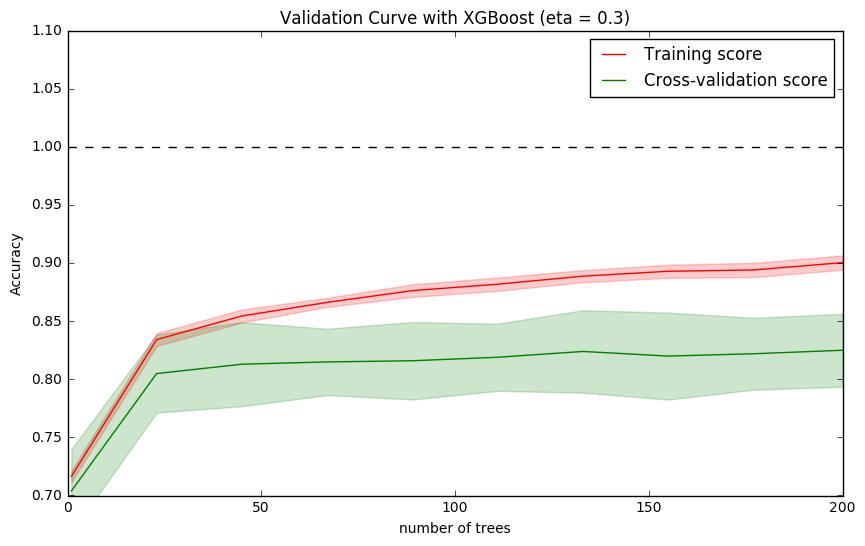

Best cross-validation result (0.82) obtained for 200 trees


In [7]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))

**Что заметно:**

- Доля правильных ответов на обучении продолжает расти, хотя на валидации - уже нет
- Когда деревьев меньше 25 разброс (variance) ошибки невелик, но и смещение (bias) велико
- Начиная с 25 деревьев, разброс ошибки начинает расти
- Модель доаольно стабильна: дальнейшее увеличение ее сложности не приводит к увеличению разброса ошибки.

Оптимальное в данном случае сочетание разброса и смещение наблюдается примерно при 50 итерациях. Хотя разброс все же велик.

### Что можно улучшить?

#### Снижение разброса
Для уменьшения сложности модели можно:
- использовать меньше признаков (например, отбор)
- использовать больше объектов (например, искусственно созданных)
- увеличить регуляризацию

В случае XGBoost можно:
- уменьшать максимальную глубину деревьев(`max_depth`)
- увеличивать значение параметра `min_child_weight`
- увеличивать значение параметра `gamma`
- добавлять больше "случайности" за счет параметров `subsample` и `colsample_bytree`
- увеличивать значение паарметров регуляризации `lambda` и `alpha`

#### Снижение смещения
Если модель слишком простая, можно:
- добавлять больше признаков (например, изобретать их),
- усложнять модель
- уменьшать регуляризацию

В случае XGBoost можно:
- увеличивать максимальную глубину деревьев(`max_depth`)
- уменьшать значение параметра `min_child_weight`
- уменьшать значение параметра `gamma`
- уменьшать значение паарметров регуляризации `lambda` и `alpha`

**Попробуем немного настроить параметры. Будем для построения каждого дерева использовать в среднем 70% случайно выбранных объектов и 60% случайно выбранных признаков. Это уменьшит разброс ошибки. Для уменьшения смещения увеличим на 1 максимальную глубину деревьев.**

In [8]:
new_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'silent': 1.0,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7, # added
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**new_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring='accuracy'
)

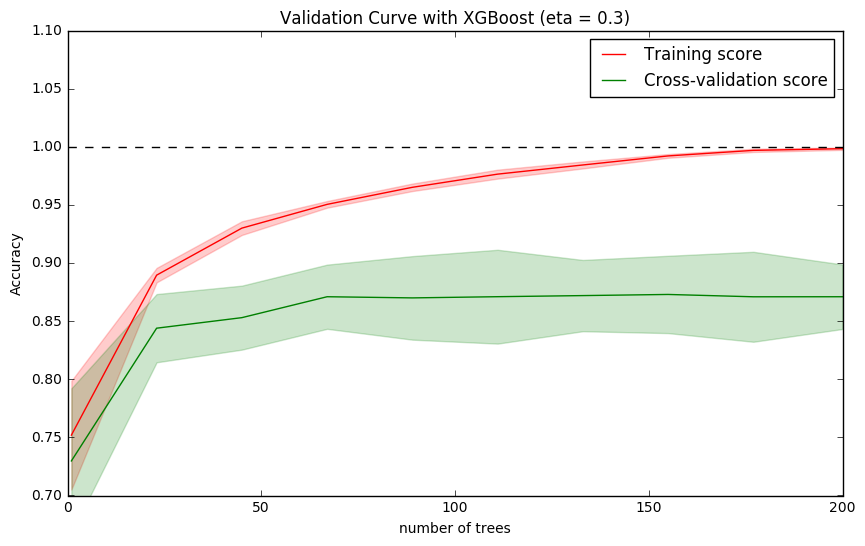

Best cross-validation result (0.87) obtained for 155 trees


In [9]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))